In [15]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from pytorchcv.model_provider import get_model as ptcv_get_model # model
import sys, os
import easydict
import torch.backends.cudnn as cudnn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import matplotlib.pyplot as plt
#%matplotlib inline 

# enable cuda devices
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from meta_neural_network_architectures import VGGReLUNormNetwork, ResNet12
from utils.parser_utils import get_args
from data import MetaLearningSystemDataLoader
from experiment_builder import ExperimentBuilder
from utils.basic import show_batch
from few_shot_learning_system import MAMLFewShotClassifier
import prompters
import torchvision.transforms as T

from data_augmentation import mixup_data, cutmix_data, random_flip, random_flip_like_torchvision
from torchvision.transforms.functional import to_pil_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Dataset 구성

In [3]:
# choices=['padding', 'random_patch', 'fixed_patch'],
method = 'fixed_patch'

datasets = "mini_imagenet"
# datasets = "tiered_imagenet"
# datasets = "CIFAR_FS"
# datasets = "CUB"

os.environ['DATASET_DIR'] = 'C:/Users/JM/PycharmProjects/MAML/datasets'
# os.environ['TEST_DATASET'] = "tiered_imagenet" # https://mtl.yyliu.net/download/Lmzjm9tX.html
# os.environ['TEST_DATASET'] = "CIFAR_FS" # https://drive.google.com/file/d/1pTsCCMDj45kzFYgrnO67BWVbKs48Q3NI/view
# os.environ['TEST_DATASET'] = "CUB" # https://data.caltech.edu/records/65de6-vp158

In [4]:
os.environ['DATASET_DIR'] = 'C:/Users/JM/PycharmProjects/MAML/datasets'
print("os.environ['DATASET_DIR'] === ", os.environ['DATASET_DIR'])

args = easydict.EasyDict(
{
  "batch_size":2,
  "image_height":84,
  "image_width":84,
  "image_channels":3,
  "gpu_to_use":0,
  "num_dataprovider_workers":4,
  "max_models_to_save":5,
  "dataset_name":"mini_imagenet_full_size",
  "dataset_path":"mini_imagenet_full_size",
  "reset_stored_paths":False,
  "experiment_name":"../MAML_Prompt_fixed_patch_5way_5shot_filter128_miniImagenet",
  "train_seed": 0, "val_seed": 0,
  "indexes_of_folders_indicating_class": [-3, -2],
  "sets_are_pre_split": True,
  "train_val_test_split": [0.64, 0.16, 0.20],
  "evaluate_on_test_set_only": False,

  "total_epochs": 100,
  "total_iter_per_epoch":500, "continue_from_epoch": -2,
  "num_evaluation_tasks":600,
  "multi_step_loss_num_epochs": 15,
  "minimum_per_task_contribution": 0.01,
  "learnable_per_layer_per_step_inner_loop_learning_rate": True,
  "enable_inner_loop_optimizable_bn_params": False,
  "evalute_on_test_set_only": False,

  "max_pooling": True,
  "per_step_bn_statistics": False,
  "learnable_batch_norm_momentum": False,
  "load_into_memory": False,
  "init_inner_loop_learning_rate": 0.01,
  "init_inner_loop_weight_decay": 0.0005,
  "learnable_bn_gamma": True,
  "learnable_bn_beta": True,

  "dropout_rate_value":0.0,
  "min_learning_rate":0.001,
  "meta_learning_rate":0.001,   "total_epochs_before_pause": 100,
  "first_order_to_second_order_epoch":-1,
  "weight_decay": 0.0,

  "norm_layer":"batch_norm",
  "cnn_num_filters":128,
  "num_stages":4,
  "conv_padding": True,
  "number_of_training_steps_per_iter":5,
  "number_of_evaluation_steps_per_iter":5,
  "cnn_blocks_per_stage":1,
  "num_classes_per_set":5,
  "num_samples_per_class":5,
  "num_target_samples": 15,
  "samples_per_iter" : 1,

  "second_order": True,
  "use_multi_step_loss_optimization":False,
  "backbone": "4-CONV",
  "arbiter": False,
  "use_bias": True,
  "prompter": True,
  "prompt_engineering": method,
  "prompt_size" : 84,
  "image_size" : 84,
  "prompt_random_init": False,
  "outer_prompt_learning_rate": 0.001,
  "inner_prompt_learning_rate": 0.01,
  "data_aug" : "random"
}
)

device = torch.cuda.current_device()
args.im_shape = (2, 3, args.image_height, args.image_width)

args.use_cuda = torch.cuda.is_available()
args.seed = 104
args.reverse_channels=False
args.labels_as_int=False
args.reset_stored_filepaths=False
args.num_of_gpus=1

args.continue_from_epoch='latest'

os.environ['DATASET_DIR'] ===  C:/Users/JM/PycharmProjects/MAML/datasets


In [5]:
# 모델을 구성한다
model = MAMLFewShotClassifier(args=args, device=device,
                              im_shape=(2, 3,
                                        args.image_height, args.image_width))

data = MetaLearningSystemDataLoader

maml_system = ExperimentBuilder(model=model, data=data, args=args, device=device)
maml_system.state

Using max pooling
meta network params
0.01
Inner Loop parameters
prompt_learning_rates_dict.prompt_weight_learning_rate torch.Size([6])
names_learning_rates_dict.layer_dict-conv0-conv-weight torch.Size([6])
names_learning_rates_dict.layer_dict-conv0-conv-bias torch.Size([6])
names_learning_rates_dict.layer_dict-conv1-conv-weight torch.Size([6])
names_learning_rates_dict.layer_dict-conv1-conv-bias torch.Size([6])
names_learning_rates_dict.layer_dict-conv2-conv-weight torch.Size([6])
names_learning_rates_dict.layer_dict-conv2-conv-bias torch.Size([6])
names_learning_rates_dict.layer_dict-conv3-conv-weight torch.Size([6])
names_learning_rates_dict.layer_dict-conv3-conv-bias torch.Size([6])
names_learning_rates_dict.layer_dict-linear-weights torch.Size([6])
names_learning_rates_dict.layer_dict-linear-bias torch.Size([6])
names_weight_decay_dict.layer_dict-conv0-conv-weight torch.Size([6])
names_weight_decay_dict.layer_dict-conv0-conv-bias torch.Size([6])
names_weight_decay_dict.layer_dict-

{'best_val_acc': 0.6903555542230606,
 'best_val_iter': 49000,
 'current_iter': 50000,
 'best_epoch': 98,
 'train_loss_mean': 0.44299627164006233,
 'train_loss_std': 0.1244340105339081,
 'train_accuracy_mean': 0.8358400019407273,
 'train_accuracy_std': 0.052117230072360736,
 'train_loss_importance_vector_0_mean': 0.006000000052154064,
 'train_loss_importance_vector_0_std': 0.0,
 'train_loss_importance_vector_1_mean': 0.006000000052154064,
 'train_loss_importance_vector_1_std': 0.0,
 'train_loss_importance_vector_2_mean': 0.006000000052154064,
 'train_loss_importance_vector_2_std': 0.0,
 'train_loss_importance_vector_3_mean': 0.006000000052154064,
 'train_loss_importance_vector_3_std': 0.0,
 'train_loss_importance_vector_4_mean': 0.9760000109672546,
 'train_loss_importance_vector_4_std': 0.0,
 'train_learning_rate_mean': 0.0010000000000000005,
 'train_learning_rate_std': 4.336808689942018e-19,
 'val_loss_mean': 0.8433790168166161,
 'val_loss_std': 0.14198213766130707,
 'val_accuracy_mean

In [6]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as T

def normalize_tensor(tensor):
    min_val = tensor.min()
    max_val = tensor.max()
    return (tensor - min_val) / (max_val - min_val + 1e-8)

def add_prompt_padding_to_image(image, prompted_weights):
    """
    image: [3, H, W] (e.g., 3x84x84)
    prompted_weights: dict with pad_up, pad_down, pad_left, pad_right
    """
    image = image.detach().cpu()

    # Detach and normalize prompts
    pad_up = normalize_tensor(prompted_weights["prompt.prompt_dict.pad_up"][0].cpu())      # [3, H_pad, W]
    pad_down = normalize_tensor(prompted_weights["prompt.prompt_dict.pad_down"][0].cpu())  # [3, H_pad, W]
    pad_left = normalize_tensor(prompted_weights["prompt.prompt_dict.pad_left"][0].cpu())  # [3, H, W_pad]
    pad_right = normalize_tensor(prompted_weights["prompt.prompt_dict.pad_right"][0].cpu())# [3, H, W_pad]

    # Step 1: Vertical concat (pad_up + image + pad_down)
    image_with_vpad = torch.cat([pad_up, image, pad_down], dim=1)  # dim=1 is height

    # Step 2: Resize left/right pad to match new height
    new_H = image_with_vpad.shape[1]
    pad_left_resized = torch.nn.functional.interpolate(pad_left.unsqueeze(0), size=(new_H, pad_left.shape[2]), mode='bilinear', align_corners=False)[0]
    pad_right_resized = torch.nn.functional.interpolate(pad_right.unsqueeze(0), size=(new_H, pad_right.shape[2]), mode='bilinear', align_corners=False)[0]

    # Step 3: Horizontal concat (pad_left + image + pad_right)
    full_image = torch.cat([pad_left_resized, image_with_vpad, pad_right_resized], dim=2)  # dim=2 is width

    return full_image  # shape: [3, H_total, W_total]

def visualize_full_prompted_image(image, prompted_weights, title="Prompted Image on Zero Input"):
    full_img = add_prompt_padding_to_image(image, prompted_weights)
    img_pil = T.ToPILImage()(full_img)

    plt.figure(figsize=(5, 5))
    plt.imshow(img_pil)
    plt.title(title)
    plt.axis("off")
    plt.show()


In [7]:
class UnNormalize:
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean).view(3, 1, 1)
        self.std = torch.tensor(std).view(3, 1, 1)
    def __call__(self, tensor):
        return tensor * self.std + self.mean

# 2. Prompt 설정

patch ==  torch.Size([3, 84, 84])


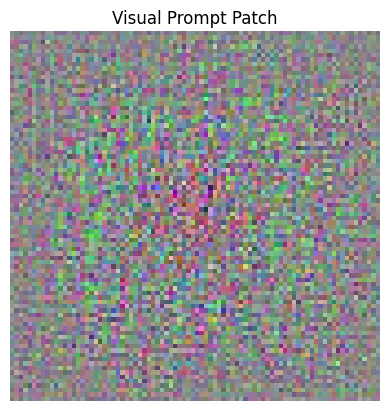

patch ==  torch.Size([3, 84, 84])


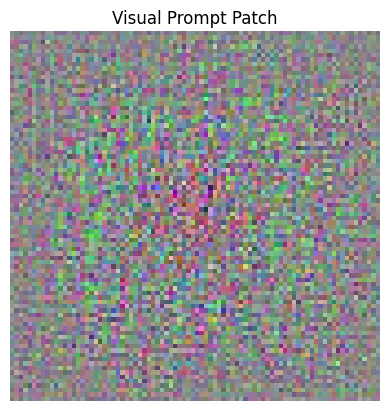

patch ==  torch.Size([3, 84, 84])


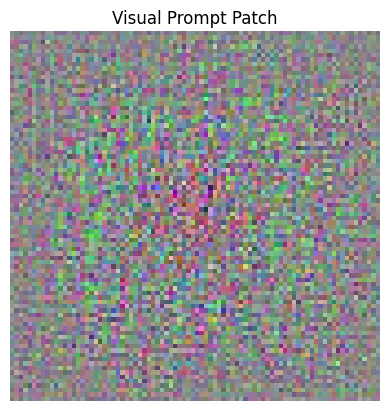

patch ==  torch.Size([3, 84, 84])


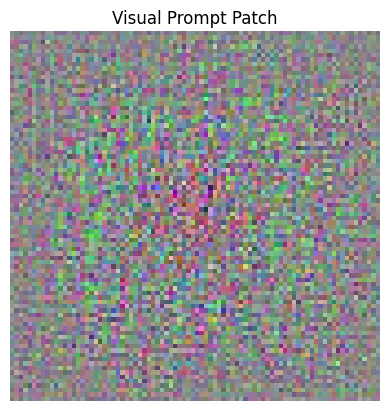

patch ==  torch.Size([3, 84, 84])


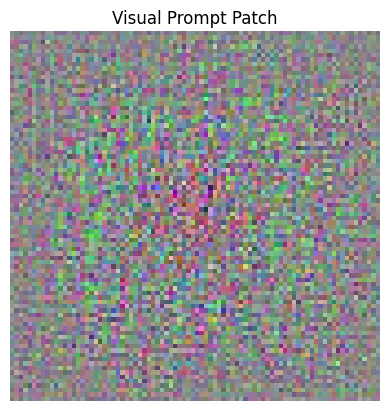

patch ==  torch.Size([3, 84, 84])


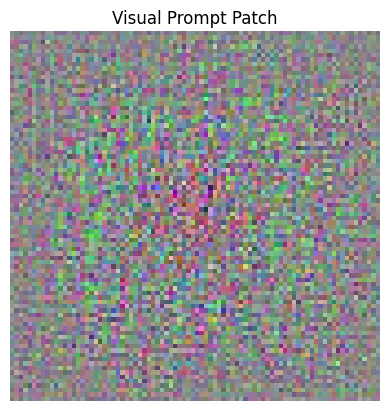

patch ==  torch.Size([3, 84, 84])


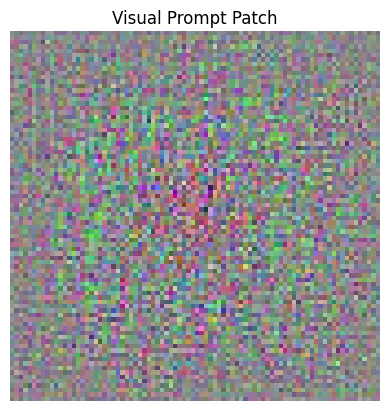

patch ==  torch.Size([3, 84, 84])


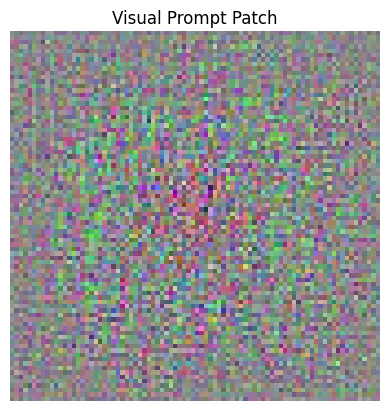

patch ==  torch.Size([3, 84, 84])


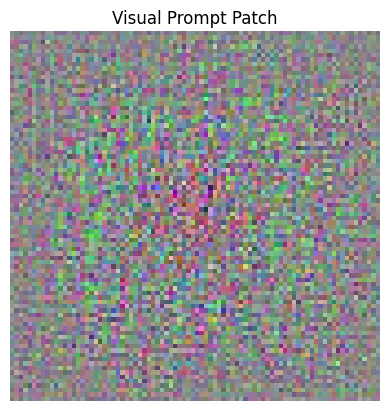

patch ==  torch.Size([3, 84, 84])


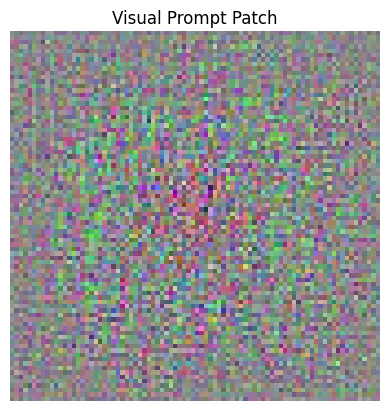

patch ==  torch.Size([3, 84, 84])


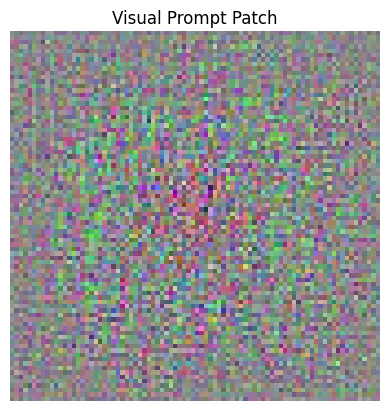

patch ==  torch.Size([3, 84, 84])


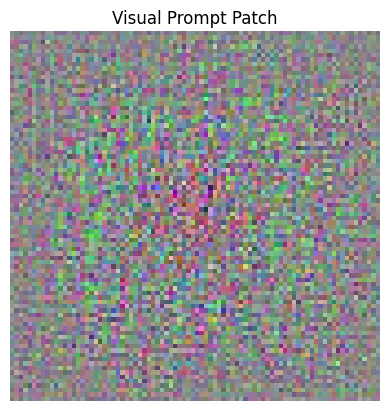

patch ==  torch.Size([3, 84, 84])


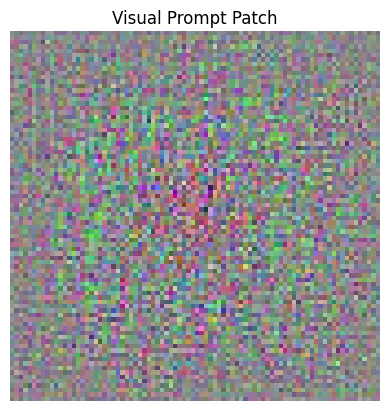

patch ==  torch.Size([3, 84, 84])


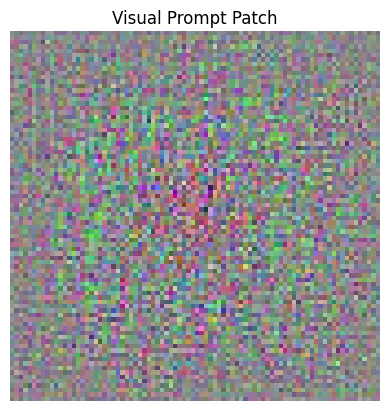

patch ==  torch.Size([3, 84, 84])


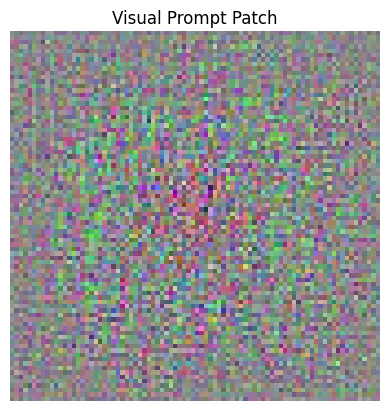

patch ==  torch.Size([3, 84, 84])


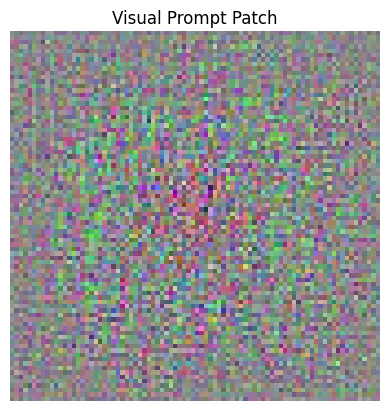

patch ==  torch.Size([3, 84, 84])


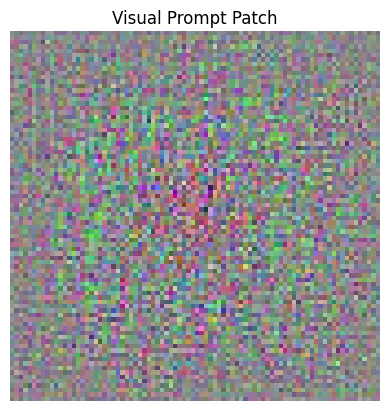

patch ==  torch.Size([3, 84, 84])


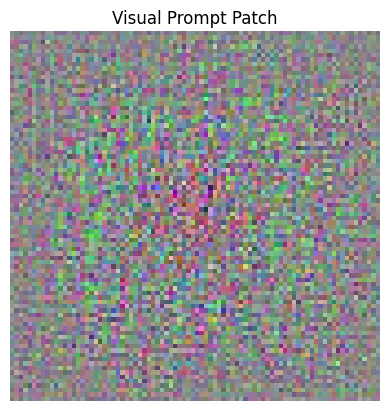

patch ==  torch.Size([3, 84, 84])


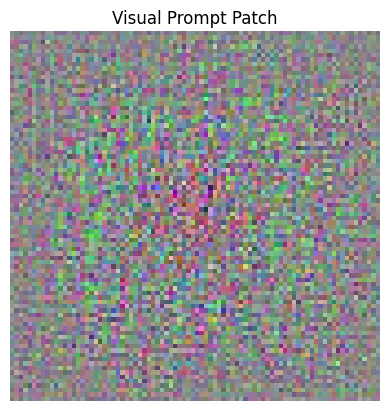

patch ==  torch.Size([3, 84, 84])


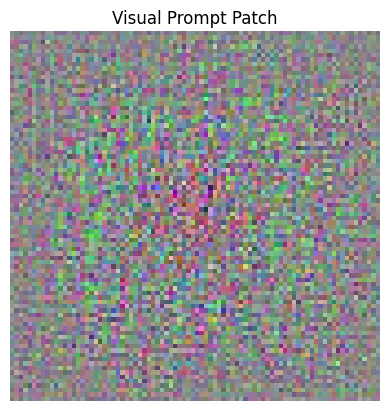

patch ==  torch.Size([3, 84, 84])


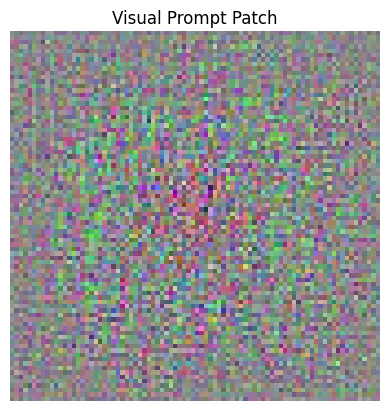

patch ==  torch.Size([3, 84, 84])


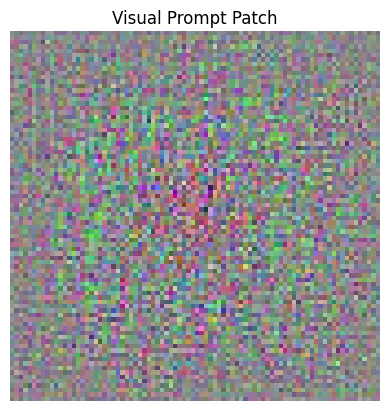

patch ==  torch.Size([3, 84, 84])


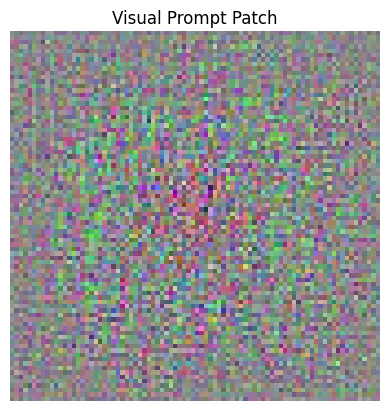

patch ==  torch.Size([3, 84, 84])


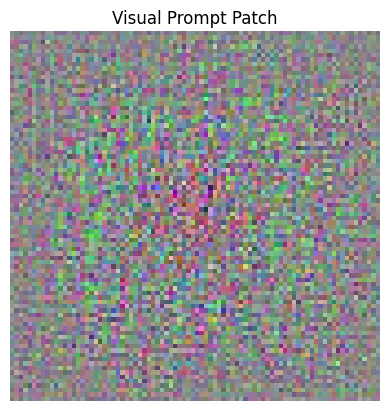

patch ==  torch.Size([3, 84, 84])


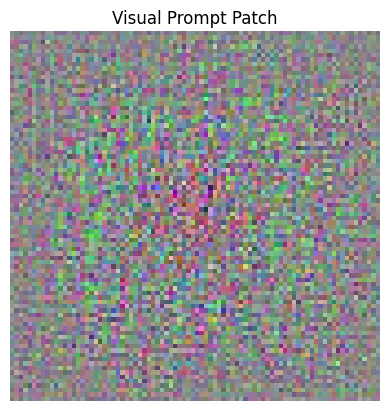

patch ==  torch.Size([3, 84, 84])


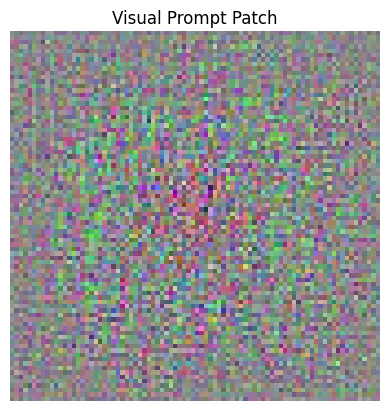

patch ==  torch.Size([3, 84, 84])


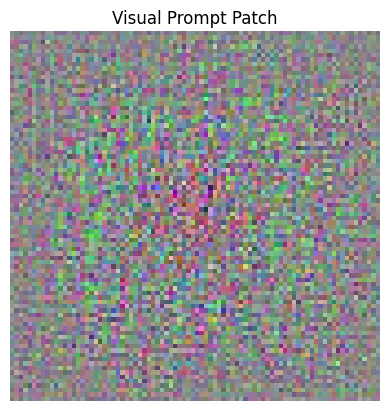

patch ==  torch.Size([3, 84, 84])


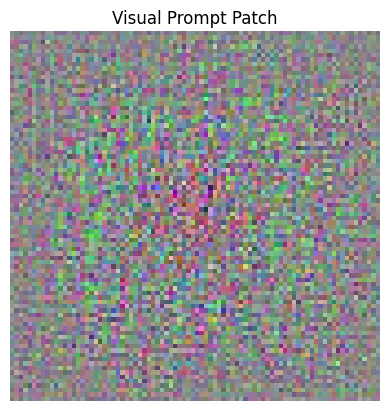

patch ==  torch.Size([3, 84, 84])


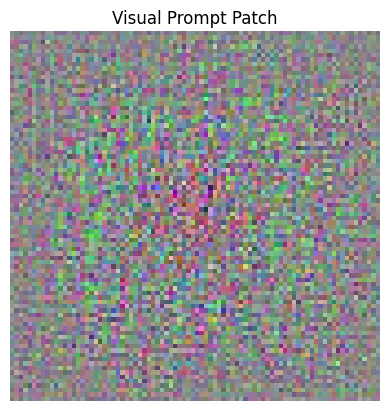

patch ==  torch.Size([3, 84, 84])


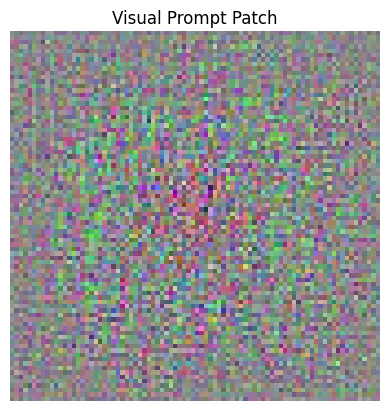

patch ==  torch.Size([3, 84, 84])


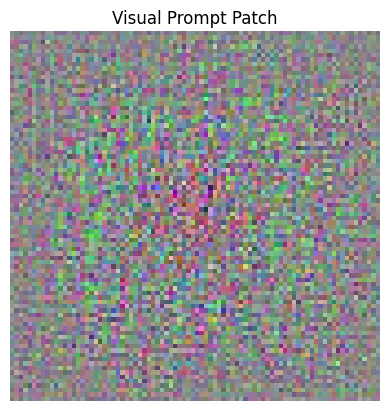

patch ==  torch.Size([3, 84, 84])


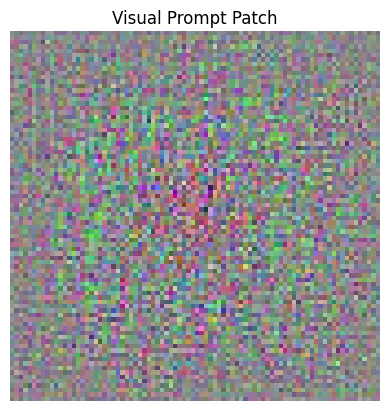

patch ==  torch.Size([3, 84, 84])


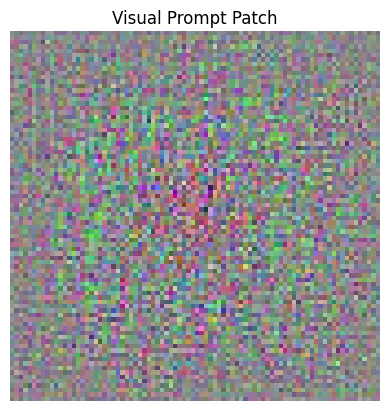

patch ==  torch.Size([3, 84, 84])


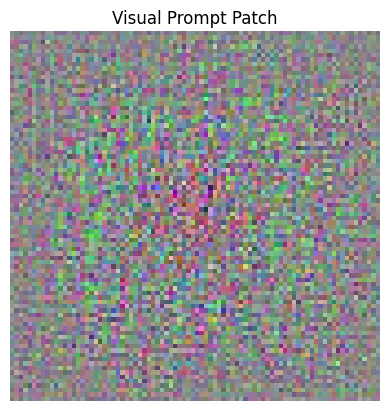

patch ==  torch.Size([3, 84, 84])


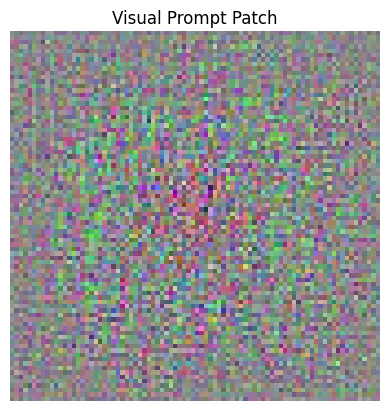

patch ==  torch.Size([3, 84, 84])


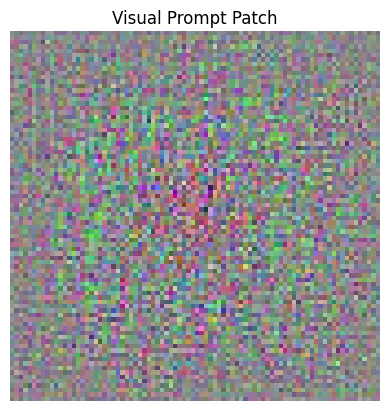

patch ==  torch.Size([3, 84, 84])


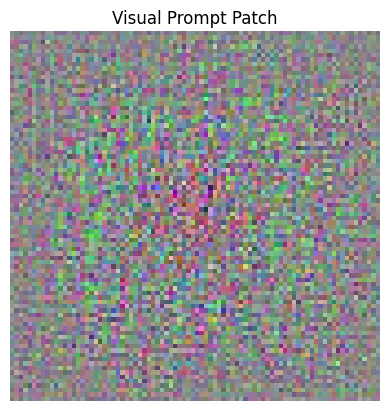

patch ==  torch.Size([3, 84, 84])


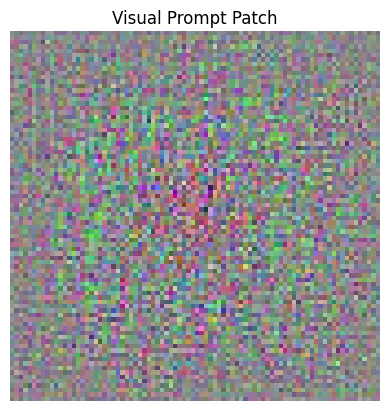

patch ==  torch.Size([3, 84, 84])


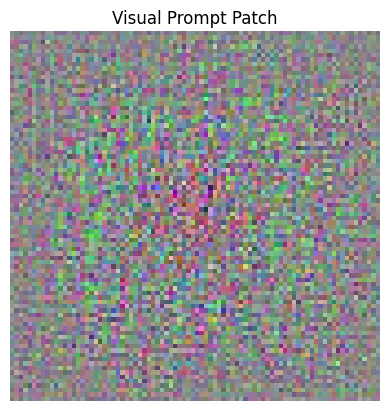

patch ==  torch.Size([3, 84, 84])


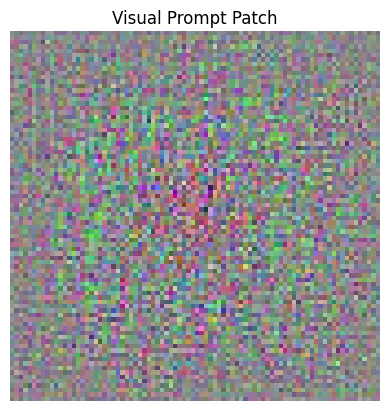

patch ==  torch.Size([3, 84, 84])


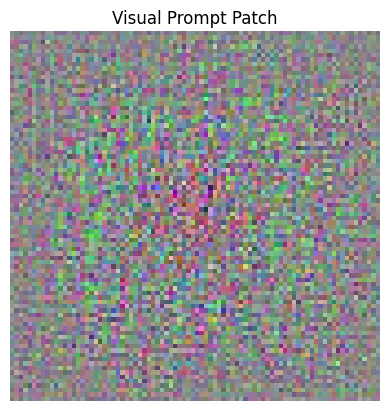

patch ==  torch.Size([3, 84, 84])


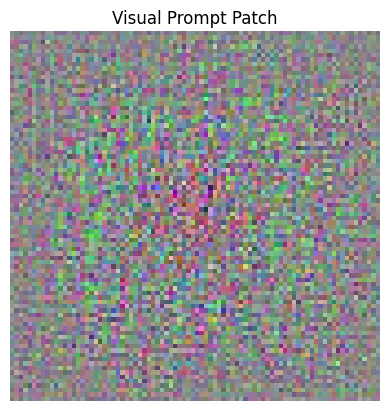

patch ==  torch.Size([3, 84, 84])


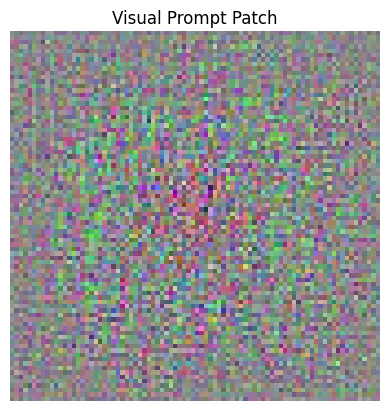

patch ==  torch.Size([3, 84, 84])


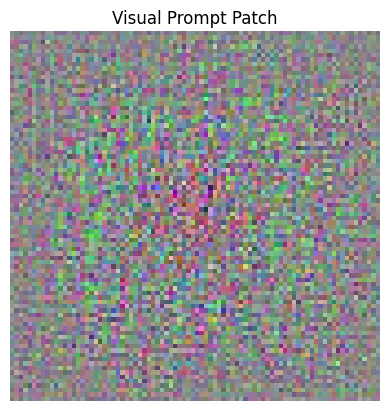

patch ==  torch.Size([3, 84, 84])


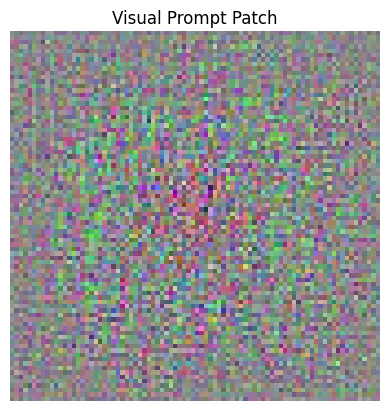

patch ==  torch.Size([3, 84, 84])


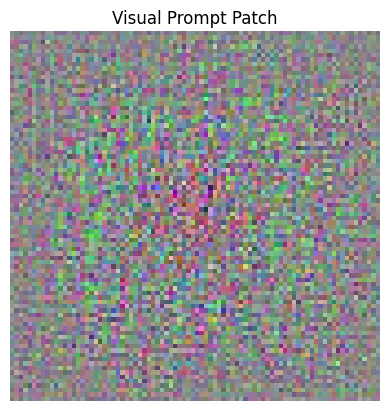

patch ==  torch.Size([3, 84, 84])


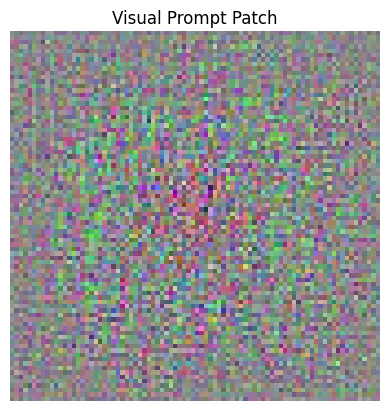

patch ==  torch.Size([3, 84, 84])


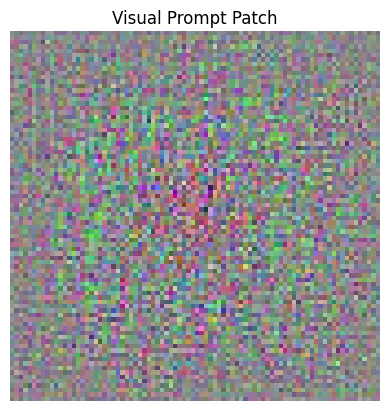

patch ==  torch.Size([3, 84, 84])


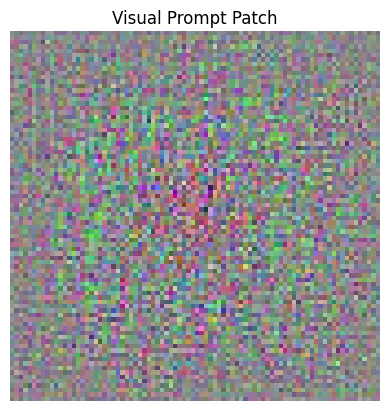

patch ==  torch.Size([3, 84, 84])


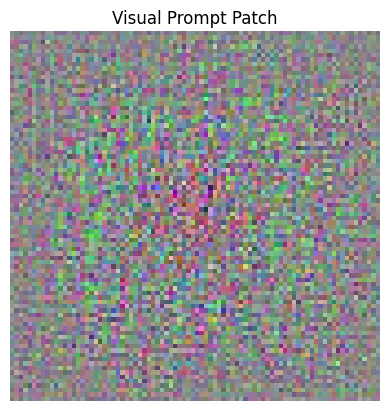

patch ==  torch.Size([3, 84, 84])


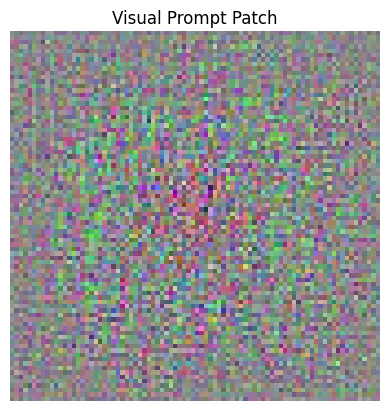

patch ==  torch.Size([3, 84, 84])


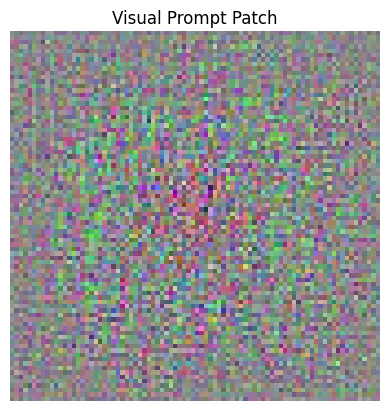

patch ==  torch.Size([3, 84, 84])


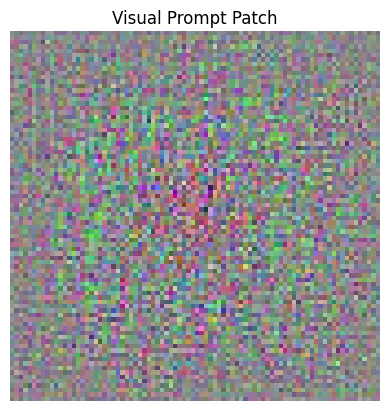

patch ==  torch.Size([3, 84, 84])


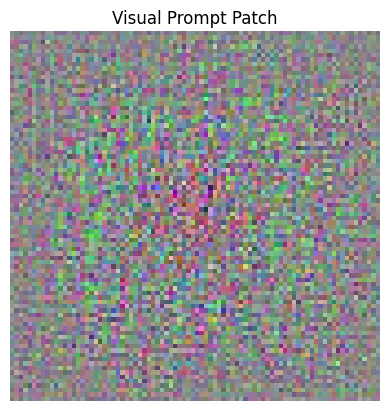

patch ==  torch.Size([3, 84, 84])


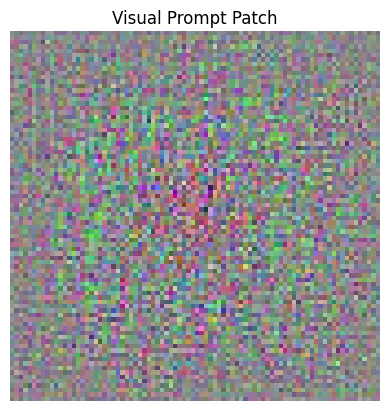

patch ==  torch.Size([3, 84, 84])


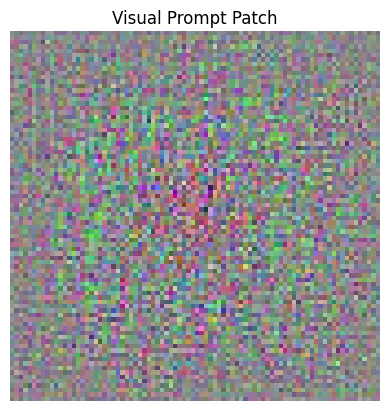

patch ==  torch.Size([3, 84, 84])


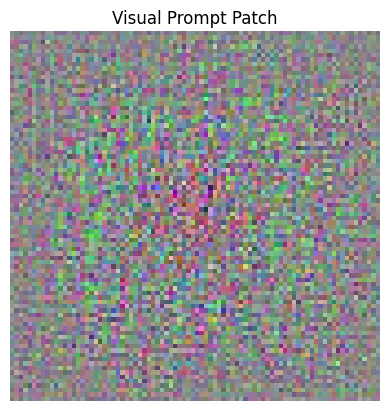

patch ==  torch.Size([3, 84, 84])


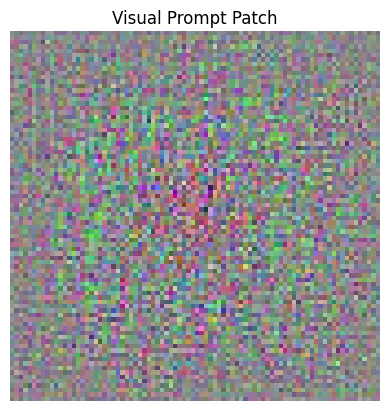

patch ==  torch.Size([3, 84, 84])


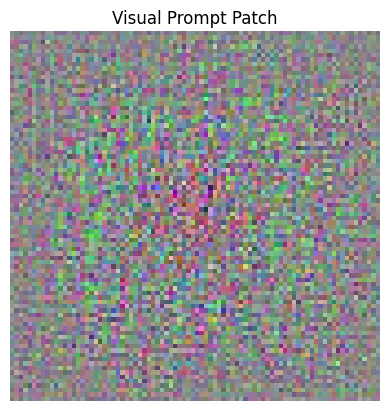

patch ==  torch.Size([3, 84, 84])


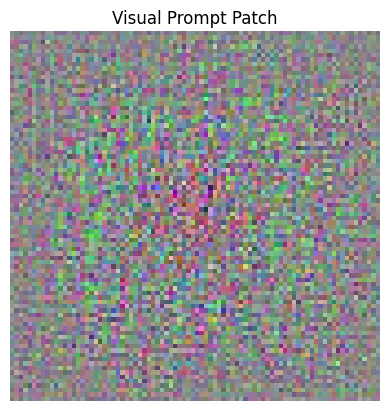

patch ==  torch.Size([3, 84, 84])


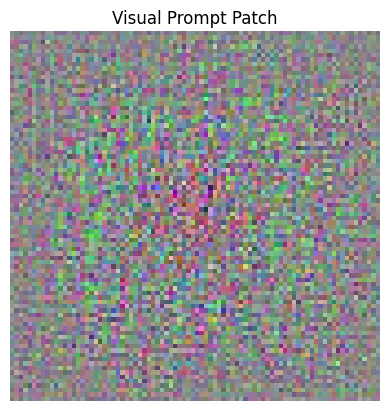

patch ==  torch.Size([3, 84, 84])


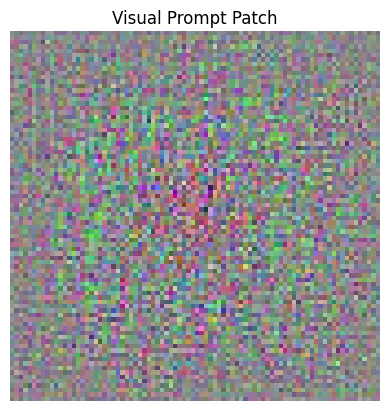

patch ==  torch.Size([3, 84, 84])


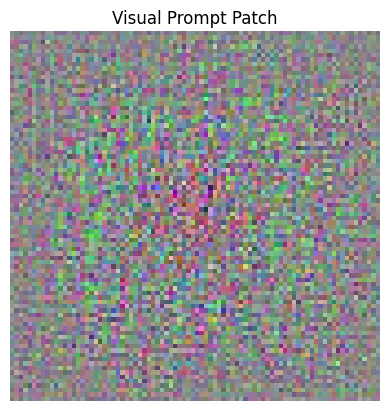

patch ==  torch.Size([3, 84, 84])


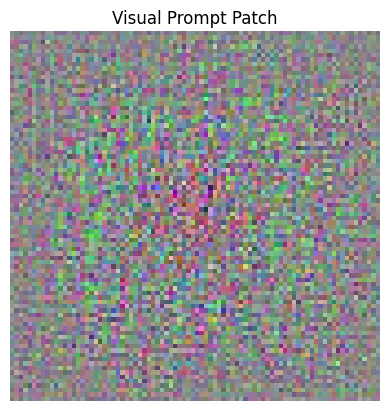

patch ==  torch.Size([3, 84, 84])


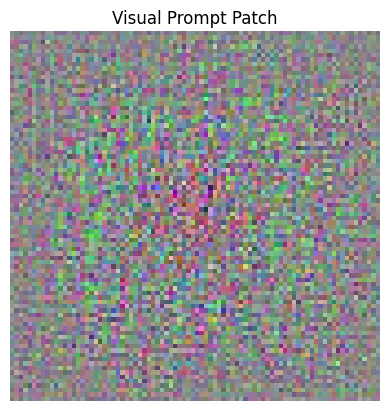

patch ==  torch.Size([3, 84, 84])


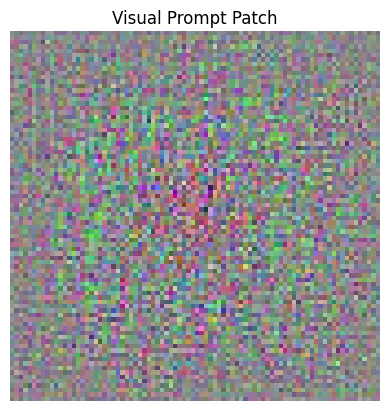

patch ==  torch.Size([3, 84, 84])


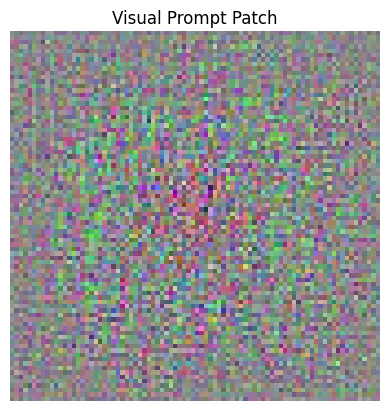

patch ==  torch.Size([3, 84, 84])


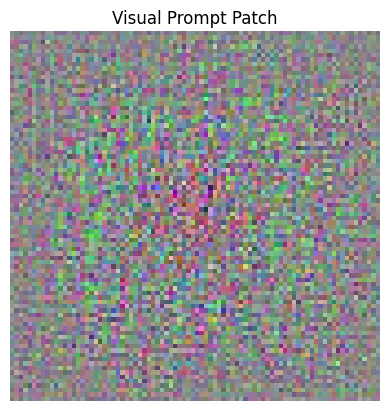

patch ==  torch.Size([3, 84, 84])


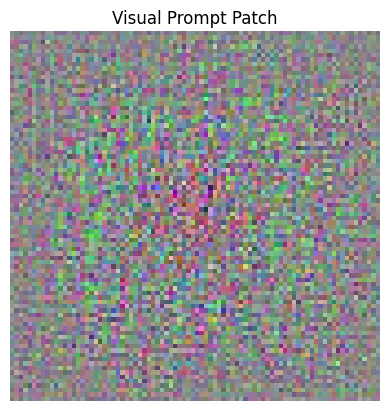

patch ==  torch.Size([3, 84, 84])


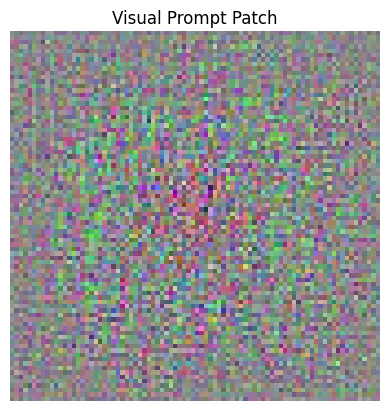

patch ==  torch.Size([3, 84, 84])


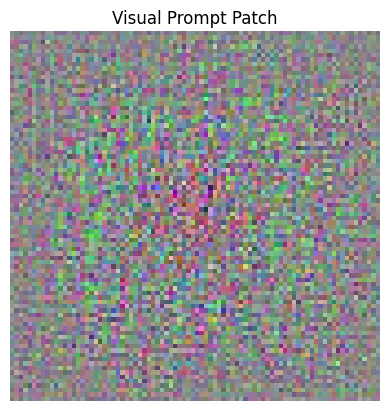

patch ==  torch.Size([3, 84, 84])


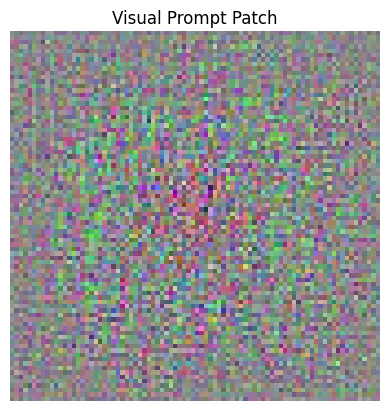

patch ==  torch.Size([3, 84, 84])


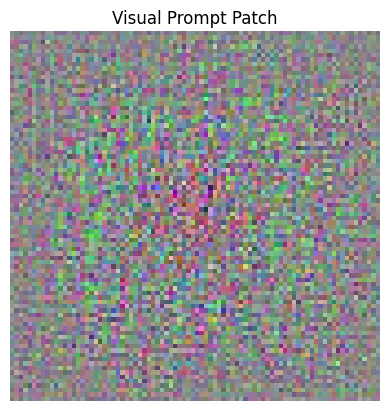

patch ==  torch.Size([3, 84, 84])


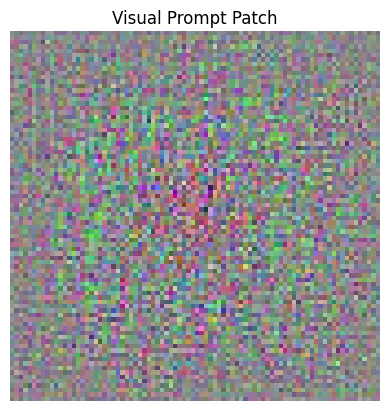

patch ==  torch.Size([3, 84, 84])


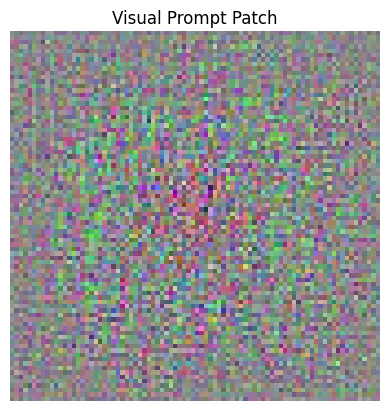

KeyboardInterrupt: 

In [18]:
train_data = maml_system.data.get_train_batches(total_batches=int(600/1), augment_images=False)

for sample_idx, train_sample in enumerate(train_data):
    
    x_support_set, x_target_set, y_support_set, y_target_set, seed = train_sample
    
    x_support_set = torch.Tensor(x_support_set).float().to(device=maml_system.model.device)
    x_target_set = torch.Tensor(x_target_set).float().to(device=maml_system.model.device)
    y_support_set = torch.Tensor(y_support_set).long().to(device=maml_system.model.device)
    y_target_set = torch.Tensor(y_target_set).long().to(device=maml_system.model.device)
    
    for task_id, (x_support_set_task, y_support_set_task, x_target_set_task, y_target_set_task) in enumerate(zip(x_support_set,
                              y_support_set,
                              x_target_set,
                              y_target_set)):
        
        
        names_weights_copy = maml_system.model.get_inner_loop_parameter_dict(maml_system.model.classifier.named_parameters())

        num_devices = torch.cuda.device_count() if torch.cuda.is_available() else 1

        names_weights_copy = {
                name.replace('module.', ''): value.unsqueeze(0).repeat(
                    [num_devices] + [1 for i in range(len(value.shape))]) for
                name, value in names_weights_copy.items()}

        prompted_weights_copy = {}
        if args.prompter:
            prompted_weights_copy = {key: value for key, value in names_weights_copy.items() if 'prompt' in key}

        names_weights_copy = {key: value for key, value in names_weights_copy.items() if 'layer_dict' in key}
        
        n, s, c, h, w = x_target_set_task.shape

        x_support_set_task = x_support_set_task.view(-1, c, h, w)
        y_support_set_task = y_support_set_task.view(-1)
        x_target_set_task = x_target_set_task.view(-1, c, h, w)
        y_target_set_task = y_target_set_task.view(-1)
        
#         patch = prompted_weights_copy['prompt.prompt_dict.patch'].squeeze()
#         print("patch == ",patch.shape)
#         patch = patch.detach().cpu()
#         patch_min = patch.min()
#         patch_max = patch.max()
#         patch_norm = (patch - patch_min) / (patch_max - patch_min + 1e-8)
        
        # PIL 이미지로 변환 후 시각화
        img = to_pil_image(patch_norm)
        plt.imshow(img)
        plt.axis('off')
        plt.title("Visual Prompt Patch")
        plt.show()

        
        for num_step in range(5):

            support_loss, support_preds = maml_system.model.net_forward(
              x=x_support_set_task,
              y=y_support_set_task,
              weights=names_weights_copy,
              prompted_weights=prompted_weights_copy,
              backup_running_statistics=num_step == 0,
              training=True,
              num_step=num_step,
              training_phase=False,
              epoch=0)
            
            names_weights_copy, prompted_weights_copy = maml_system.model.apply_inner_loop_update(
             loss=support_loss,
             names_weights_copy=names_weights_copy,
             prompted_weights_copy=prompted_weights_copy,
             use_second_order=True,
             current_step_idx=num_step,
             current_iter='test',
             training_phase=False)
            
            # print("num_step == ", num_step)
            # prompted_images = maml_system.model.classifier.prompt(x=x_support_set_task, prompted_params=prompted_weights_copy)    
            # show_batch(images=prompted_images, labels=y_support_set_task, datasets=datasets)
            
            if num_step == 4:
                target_loss, target_preds = maml_system.model.net_forward(
                    x=x_target_set_task,
                    y=y_target_set_task,
                    weights=names_weights_copy,
                    prompted_weights=prompted_weights_copy,
                    backup_running_statistics=False, training=True,
                    num_step=num_step,
                    training_phase=False,
                    epoch=0)        